In [1]:
# Обязательно запускать всегда для проверки. Версия должна быть 3.8.12
!python --version

# Также выполняется установка необходимых версий пакетов
!pip install pymc3==3.8 numpy==1.18.0 pandas==1.0.0 seaborn==0.9.1 statsmodels==0.11.0 arviz==0.11.0 scikit-learn==1.0 scipy==1.7.1 matplotlib==3.4.3 openpyxl==3.0.3 xlrd==1.2.0 theano==1.0.5 

Python 3.8.10
You should consider upgrading via the '/home/vladoo/Projects/jn/bin/python -m pip install --upgrade pip' command.


In [2]:
# Программа multi_factor_monthly_model - обрабатывает данные по курсу рубль-доллар, ценам на нефть Brent,
# 5 летним senior CDS на РФ, золотовалютным запасам РФ и валютными интервенциями ЦБ

# Регрессии используются для поиска взаимосвязи и прогнозирования в тестовом периоде по данным периода обучения
# Методы: OLS(МНК), GLS, ARIMA (1,1,0), Регрессия Байеса и BayesianRidge

# Запускаем необходимые для работы пакеты, установить недостающие можно через pip install *package name*
# Для расчета Байесовской регрессии и корректной работы pymc3 нужна версия pandas не ниже 0.25

import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import warnings
import statsmodels.api as sm
import pymc3 as pm
import math
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from sklearn.linear_model import LinearRegression
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
warnings.filterwarnings('ignore')

# устанавливаем путь к файлу с данными

# %cd C:/Users/ivani/models/econometric1
# %cd /Users/vladoo/Work/shape_error
# %cd /home/jovyan
%cd /home/vladoo/Projects/shape_error

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


/home/vladoo/Projects/shape_error


In [3]:
# Преобразуем данные в df с единым индексом и удалим лишние столбцы

intervention = pd.read_excel('intervention.xlsx')
intervention['Date'] = pd.to_datetime(intervention['Date'], infer_datetime_format=True)
intervention.set_index('Date', inplace=True)

currency = pd.read_excel('currency.xlsx', index_col=0) 

brent = pd.read_excel('brent.xlsx', index_col=0) 

cds = pd.read_csv('CDS_Daily.csv', sep='|', decimal=',') 
cds['Date'] = pd.to_datetime(cds['Date'], infer_datetime_format=True)
cds.set_index('Date', inplace=True)
cds = cds['price']
cds = cds.str.replace(',', '.')
cds=cds.astype(float)

print(intervention.index.is_unique)
print(cds.index.is_unique)
print(brent.index.is_unique)
print(currency.index.is_unique)

#intervention.drop_duplicates(inplace=True) # Если выше есть False, то надо удалить дубликаты в этом df

data = pd.concat([currency, brent, intervention, cds], axis=1)
data.dropna(inplace=True)
data.columns = ['RUB','Brent','CBR_INTERVENTIONS','RUSSIAN_5YR_CDS']
data

True
True
True
True


,RUB,Brent,CBR_INTERVENTIONS,RUSSIAN_5YR_CDS
Date,,,,
2011-02-16,29.272,103.78,10.25,-16.779
2011-02-17,29.271,102.59,10.25,-16.777
2011-02-18,29.171,102.52,10.24,-16.677
2011-02-21,29.161,105.74,3.14,-16.627
2011-02-22,29.246,105.78,16.34,-16.399
...,...,...,...,...
2022-02-22,78.590,93.85,0.00,312.940
2022-02-23,81.140,94.00,0.00,343.620
2022-02-24,84.000,95.42,0.00,412.480


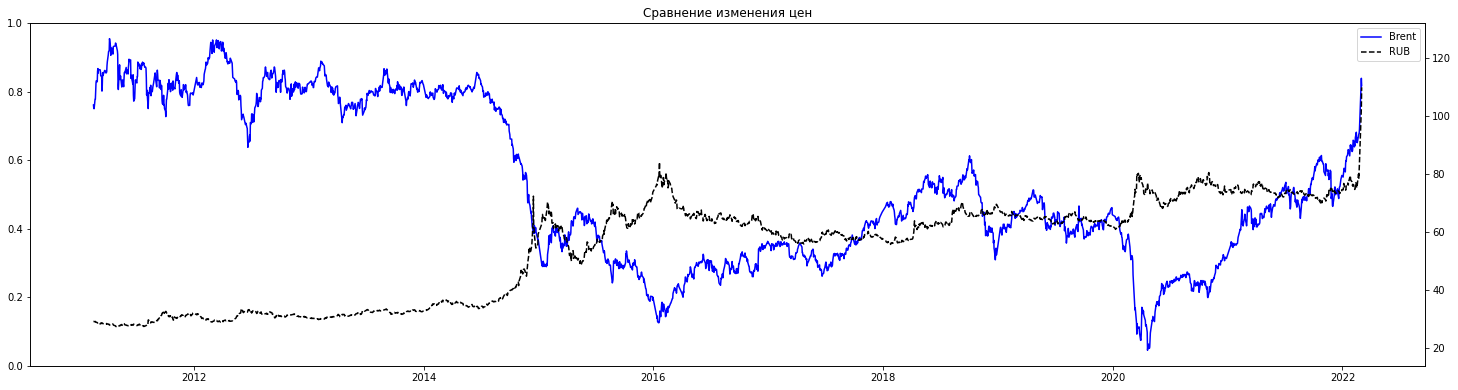

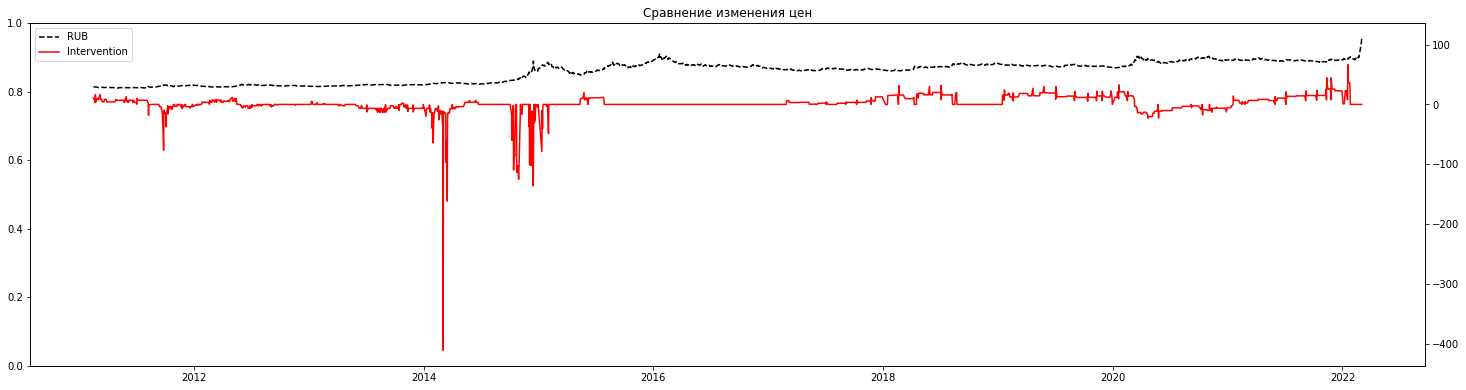

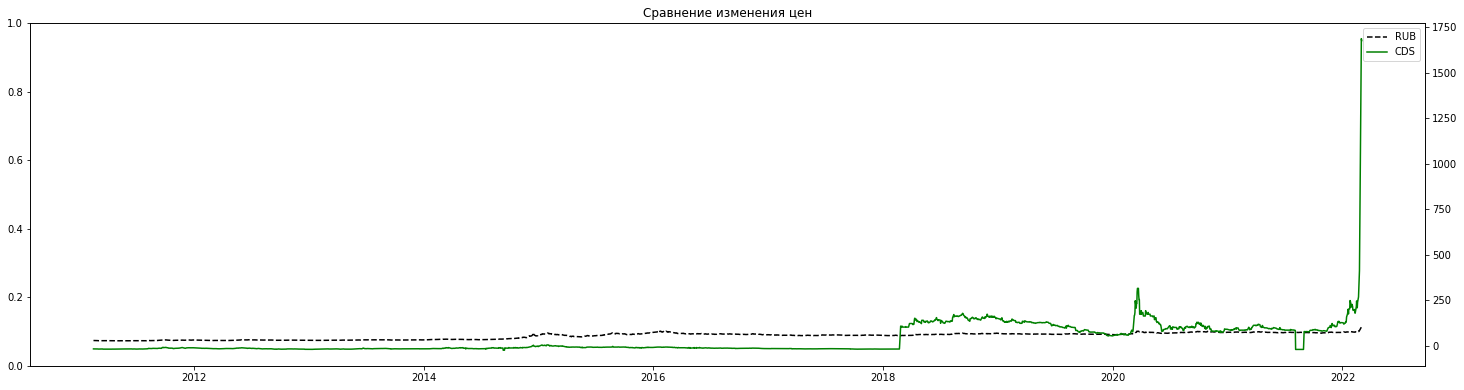

In [4]:
#Временной промежуток — с 2011 по март 2020 
#И вот какая динамика наблюдается за этот период, если выразить стоимость рубля в долларах:
fig, ax = plt.subplots()
ax2=ax.twinx()
data['Brent'].plot(figsize=(25,7), label='Brent', ax=ax2, color='blue')
data['RUB'].plot(figsize=(25,7), label='RUB', title='Сравнение изменения цен', ax=ax2, style=['k--'])
plt.legend()

fig, ax = plt.subplots()
ax2=ax.twinx()
data['RUB'].plot(figsize=(25,7), label='RUB', title='Сравнение изменения цен', ax=ax2, style=['k--'])
data['CBR_INTERVENTIONS'].plot(figsize=(25,7), label='Intervention', ax=ax2, color='r')
plt.legend()

fig, ax = plt.subplots()
ax2=ax.twinx()
data['RUB'].plot(figsize=(25,7), label='RUB', title='Сравнение изменения цен', ax=ax2, style=['k--'])
data['RUSSIAN_5YR_CDS'].plot(figsize=(25,7), label='CDS', ax=ax2, color='green')
plt.legend()

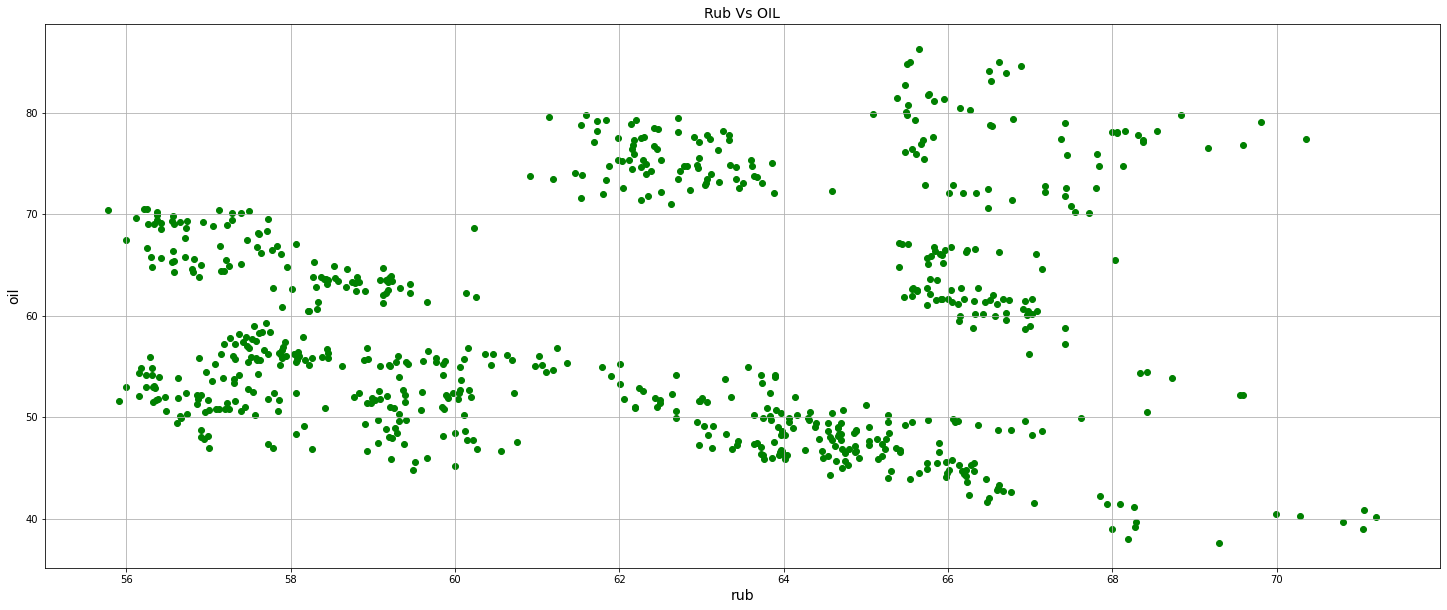

In [5]:
# Обучающее множество

oil = data.loc["2016-03-06":"2019-03-10", "Brent"]
rub = data.loc["2016-03-06":"2019-03-10", "RUB"]
# oil = data.loc["2015-09-09":"2017-01-30", "Brent"]
# rub = data.loc["2015-09-09":"2017-01-30", "RUB"]
df_train = pd.concat([oil, rub, data['RUSSIAN_5YR_CDS'],
                     data['CBR_INTERVENTIONS']], axis=1, keys=['oil', 'rub','cds','inter'])
df_train.dropna(inplace=True)

# Тестовое множество. В этом периоде мы будем сравнивать результаты прогнозов с фактическим курсом

oil = data.loc["2019-03-28":"2022-03-04", "Brent"]
rub = data.loc["2019-03-28":"2022-03-04", "RUB"]
df_test = pd.concat([oil, rub, data['RUSSIAN_5YR_CDS'],
                     data['CBR_INTERVENTIONS']], axis=1, keys=['oil', 'rub','cds','inter'])
df_test.dropna(inplace=True)

# Визуализация зависимости на обучающем множестве OIL

rcParams['figure.figsize'] = 25, 10
plt.scatter(df_train['rub'], df_train['oil'], color='green')
plt.title('Rub Vs OIL', fontsize=14)
plt.xlabel('rub', fontsize=14)
plt.ylabel('oil', fontsize=14)
plt.grid(True)
plt.show()

In [6]:
# !!! Для корректной работы программы должно выполняться 2 условия по длине выборок

# 1  Длина тестового множества должна = длине обучающего
# 2  Длины обоих множеств должны быть кратны 4

# Проверить длину рядов можно командами снизу

print(len(df_test))
print(len(df_train))

# Проверка

if len(df_test) != len(df_train):
    print('! ВНИМАНИЕ: Длина обучающей и тестовой выборки не совпадают. Для корректной работы GLS и ARIMA рекомендуется отредактировать периоды')
else:
    print('Этап 1: Длина выборок совп>адает!')

if (len(df_test) % 4 == 0 and len(df_train) % 4 == 0):
    print('Этап 2: выборки кратны 4 - можно продолжать работу')
else:
    print('! ВНИМАНИЕ: выборки не кратны 4. Требуется исправить длину выборок, чтобы они делились на 4 без остатка')

716
716
Этап 1: Длина выборок совп>адает!
Этап 2: выборки кратны 4 - можно продолжать работу


In [7]:
# Основное отличие от предыдущего кода - мультифакторная модель. Соберем наши факторы в переменной х1

x1=df_train[['oil','cds','inter']]
Y=df_train['rub']

                            OLS Regression Results                            
Dep. Variable:                    rub   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     280.5
Date:                Fri, 11 Mar 2022   Prob (F-statistic):          3.80e-120
Time:                        10:59:52   Log-Likelihood:                -1702.9
No. Observations:                 716   AIC:                             3414.
Df Residuals:                     712   BIC:                             3432.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         73.4734      0.805     91.225      0.0

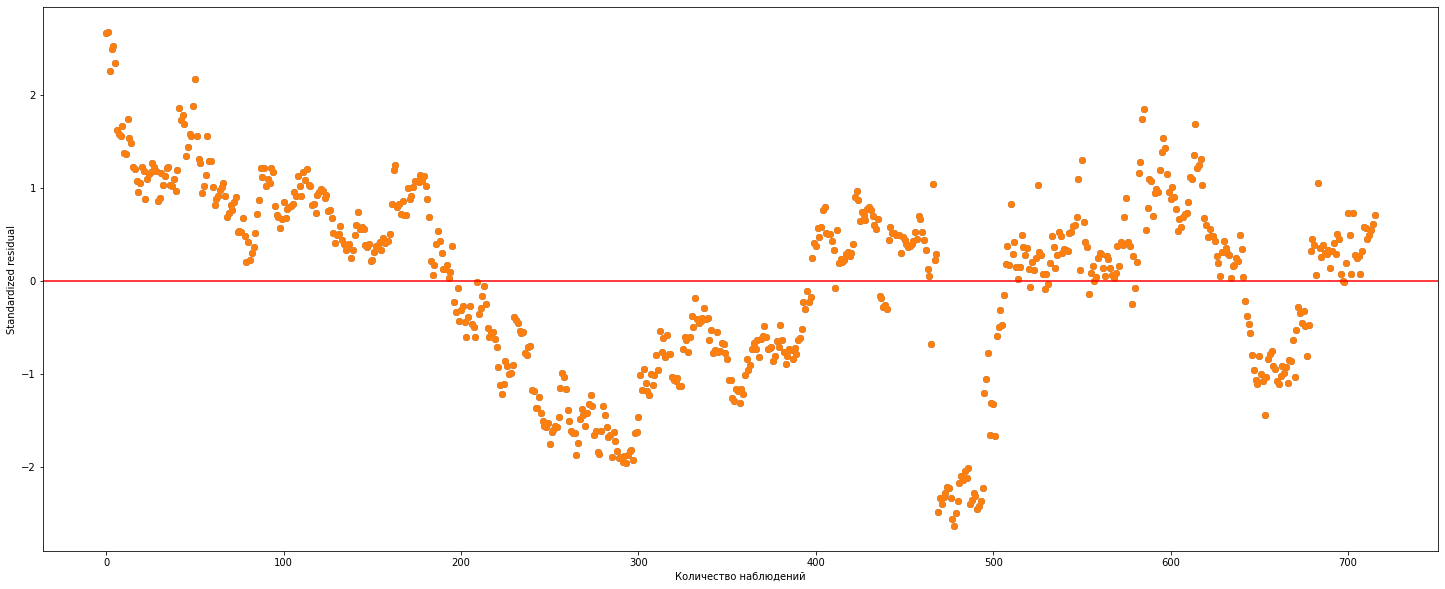

In [8]:
# OLS
               
x = sm.add_constant(x1)
x2 = sm.add_constant(df_test[['oil','cds','inter']])

results = sm.OLS(Y,x).fit()
pred_ols = results.predict(x2)

print (results.summary())

# Тест Дарбина-Уотсона говорит о наличии автокорреляции

# Графики распределения ошибок и интервалы

 
stdres = pd.DataFrame(results.resid_pearson)
plt.plot(stdres, 'o', ls = 'None')

stdres = pd.DataFrame(results.resid_pearson)
plt.plot(stdres, 'o', ls = 'None')
l = plt.axhline(y=0, color = 'r')
 
 
plt.ylabel('Standardized residual')
plt.xlabel('Количество наблюдений')
plt.show()

                             ARIMA Model Results                              
Dep. Variable:                  D.rub   No. Observations:                  715
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -531.263
Method:                       css-mle   S.D. of innovations              0.509
Date:                Fri, 11 Mar 2022   AIC                           1074.525
Time:                        10:59:54   BIC                           1101.959
Sample:                             1   HQIC                          1085.119
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1530      0.162      0.943      0.345      -0.165       0.471
oil            -0.0035      0.003     -1.145      0.252      -0.009       0.002
cds             0.0006      0.000      1.514    

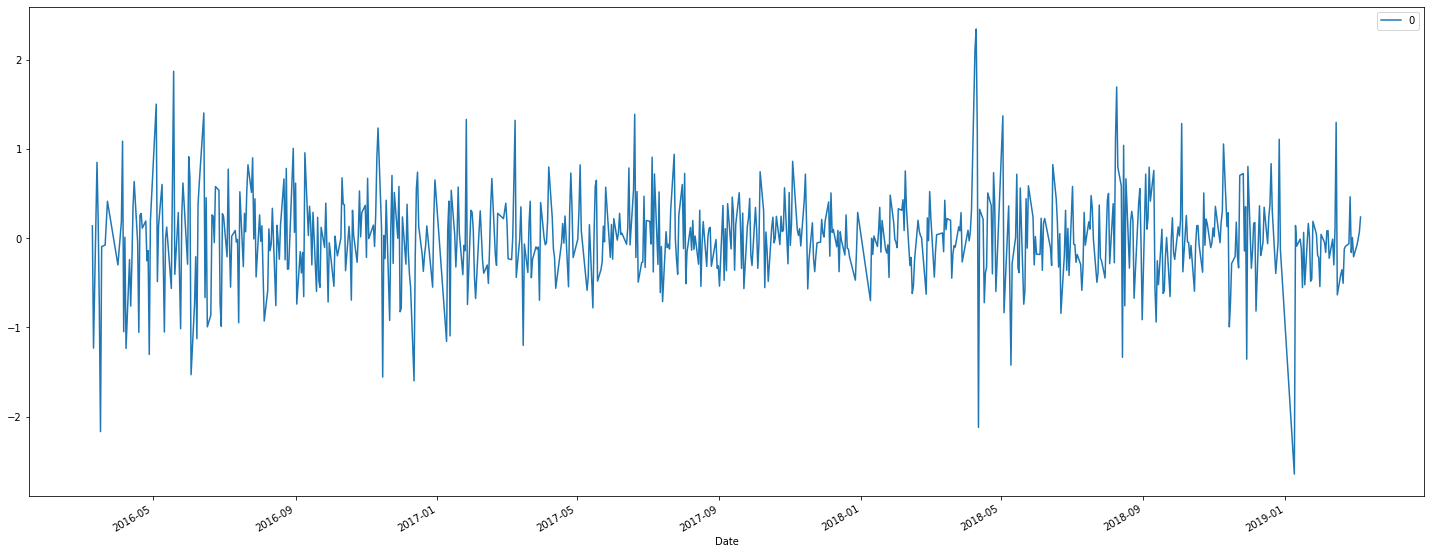

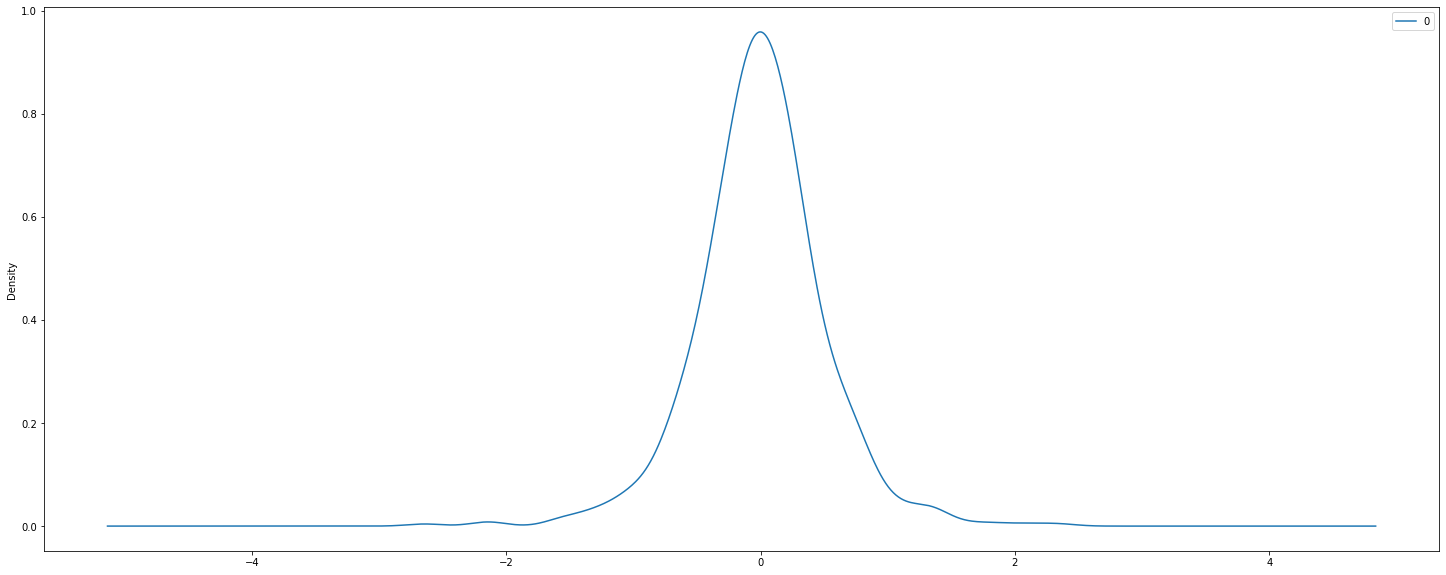

                0
count  715.000000
mean    -0.000006
std      0.509047
min     -2.643704
25%     -0.272269
50%     -0.002383
75%      0.273203
max      2.343744


In [9]:
# ARIMA (1,1,0)

arima = ARIMA(endog=Y, exog=x1, order=(1,1,0))
arima_results = arima.fit(disp=0)
print(arima_results.summary())

# Визуализация распределения

residuals = pd.DataFrame(arima_results.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

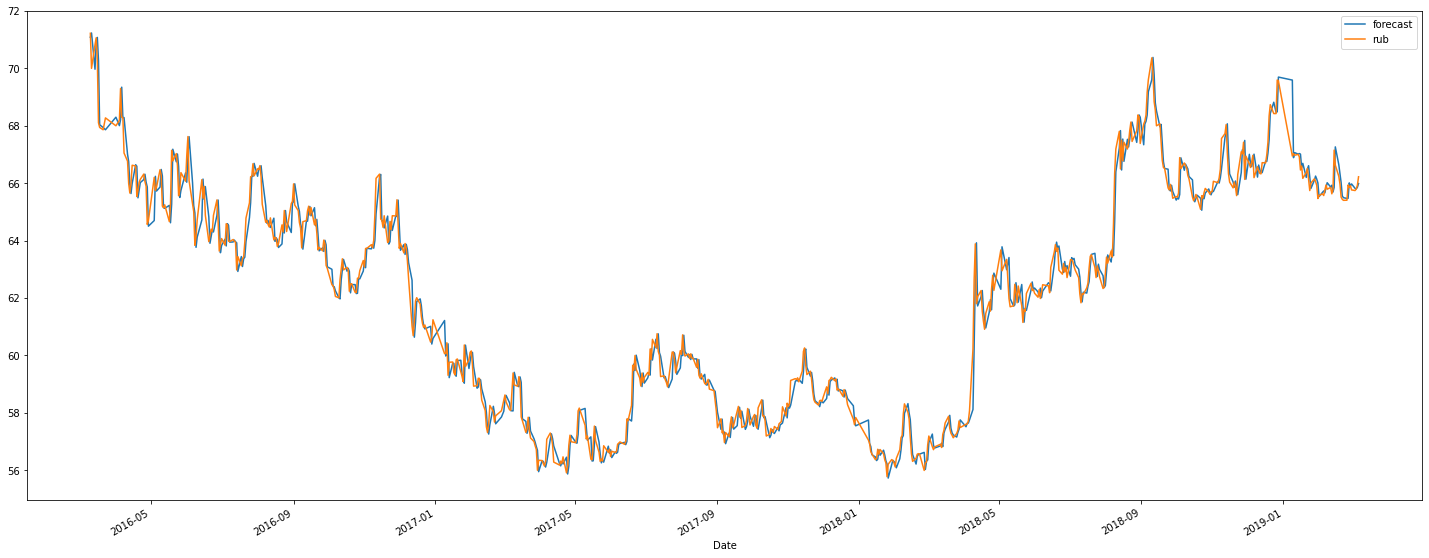

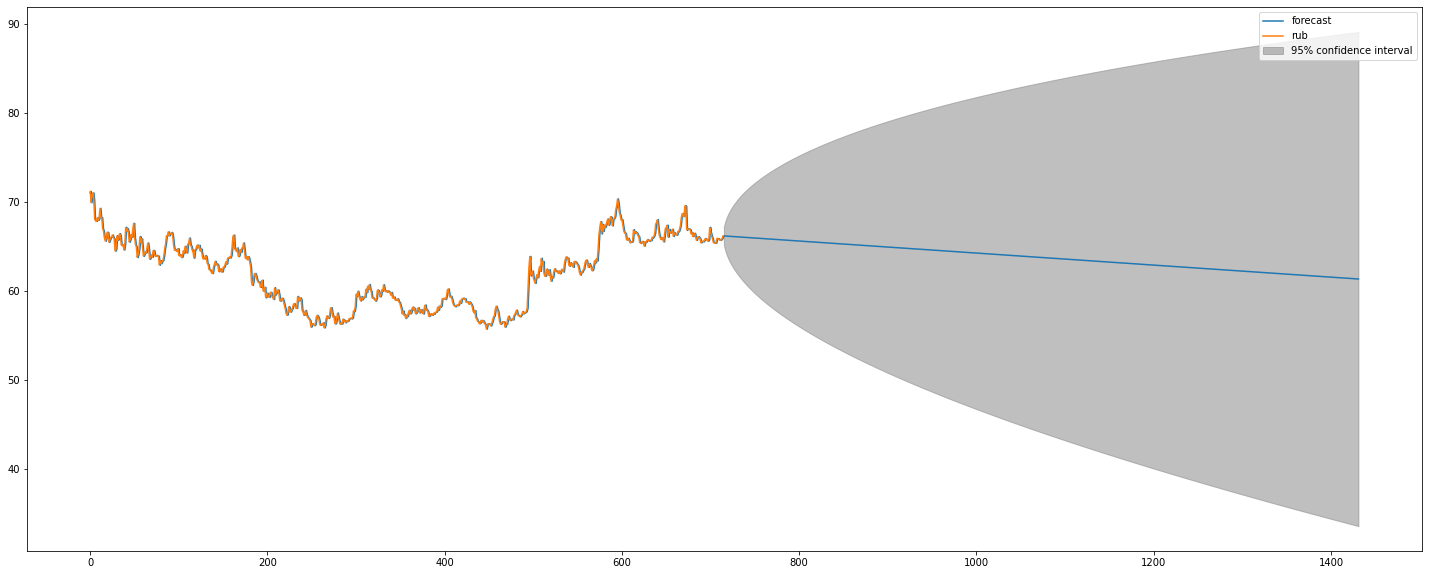

In [10]:
# ARIMA на обучающей выборке

arima_results.plot_predict(end=len(df_train)-1, exog=x2, alpha=0.05) # end = количество наблюдений - 1

# ARIMA прогноз на основе обучающей выборки. Однозначно неподходящий метод

model = ARIMA(Y, order=(1,1,0))
arima_results2 = model.fit(disp=0)
arima_results2.plot_predict(end=(len(df_train))*2,alpha=0.05) # значение по умолчанию = количество наблюдений * 2
pred_arima = arima_results2.predict(end=len(df_train)) # значение по умолчанию = количество наблюдений

                            GLS Regression Results                            
Dep. Variable:                    rub   R-squared:                       0.222
Model:                            GLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     67.81
Date:                Fri, 11 Mar 2022   Prob (F-statistic):           1.40e-38
Time:                        10:59:57   Log-Likelihood:                -630.43
No. Observations:                 716   AIC:                             1269.
Df Residuals:                     712   BIC:                             1287.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         70.8566      0.862     82.209      0.0

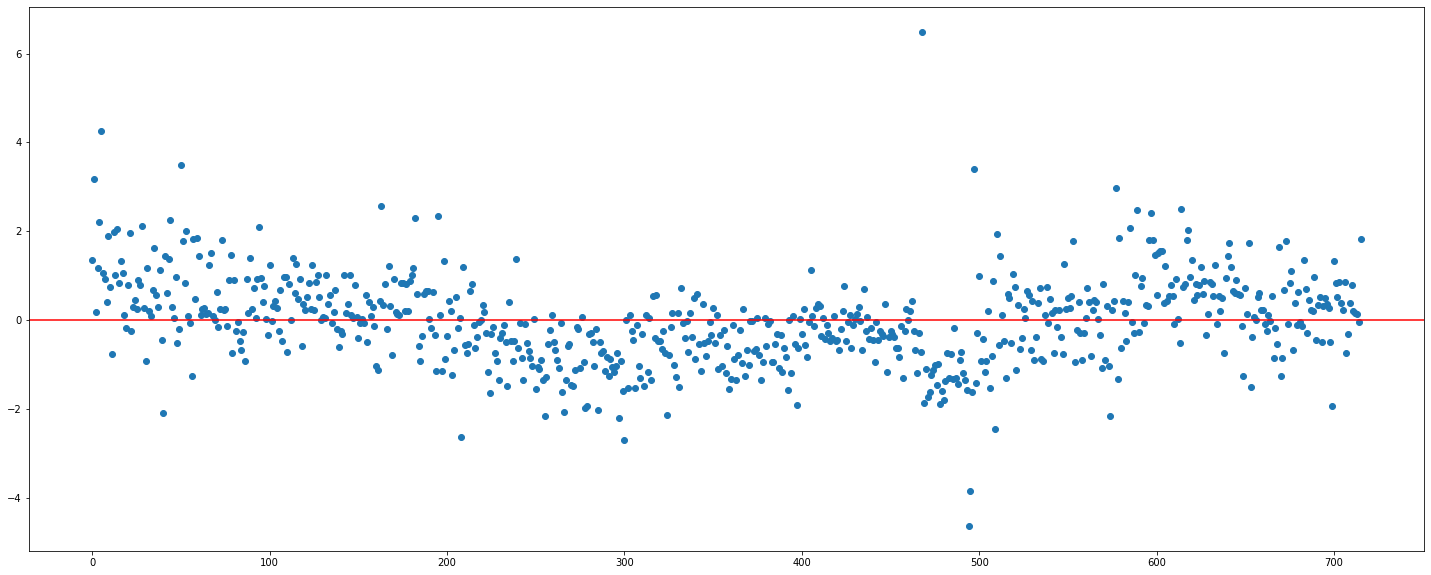

In [11]:
##GLS 

ols_resid = results.resid
res_fit = sm.OLS(list(ols_resid[4:]), list(ols_resid[:-4])).fit()
rho = res_fit.params
from scipy.linalg import toeplitz
order = toeplitz(np.arange(len(df_train))) #np.arange(X) = количеству наблюдений
sigma = rho**order
gls_model = sm.GLS(Y, x, sigma=sigma)
gls_results = gls_model.fit()
print(gls_results.summary())

stdresgls = pd.DataFrame(gls_results.resid_pearson)

# Результаты близки к OLS

pred_gls = gls_results.predict(x2) # Прогнозные данные пригодятся в дальнейшем для графиков и ошибок

# Инфографика по распределению ошибок (q-q plot)
 
plt.plot(stdresgls, 'o', ls = 'None')
lgls = plt.axhline(y=0, color = 'r')

In [12]:
# Регрессия Байеса OIL

# Внимание! Расчет займет 10-20 минут и зависит от количества итераций в последней строке

df = df_train
df['Intercept'] = 1
X = df.loc[:, ['Intercept', 'oil']]
y = df.loc[:, 'rub']
df.head()

with pm.Model() as linear_model:
    
    # Параметры модели
    
    intercept = pm.Normal('Intercept', mu = 0, sd = 10)
    
    # Slope 
    slope = pm.Normal('slope', mu = 0, sd = 10)
    
    # Standard deviation
    sigma = pm.HalfNormal('sigma', sd = 10)
    
    # Estimate of mean
    mean = intercept + slope * X.loc[:, 'oil']
    
    # Observed values
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = y.values)
    
    # Sampler
    step = pm.NUTS()

    # расчет займет 10-20 минут и зависит от количества итераций ниже
    
    linear_trace_oil = pm.sample(int(len(df_test)/4), step)

Only 179 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, slope, Intercept]
Sampling 4 chains, 0 divergences: 100%|█| 2716/2716 [00:02<00:00, 1057.99draws/s
The acceptance probability does not match the target. It is 0.8933634443959333, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9019972315710875, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9423260425849814, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9386816703741527, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [13]:
# Регрессия Байеса CDS

# Внимание! Расчет займет 10-20 минут и зависит от количества итераций в последней строке

df = df_train
df['Intercept'] = 1
X = df.loc[:, ['Intercept', 'cds']]
y = df.loc[:, 'rub']
df.head()

with pm.Model() as linear_model:
    
    # Параметры модели
    
    intercept = pm.Normal('Intercept', mu = 0, sd = 10)
    
    # Slope 
    slope = pm.Normal('slope', mu = 0, sd = 10)
    
    # Standard deviation
    sigma = pm.HalfNormal('sigma', sd = 10)
    
    # Estimate of mean
    mean = intercept + slope * X.loc[:, 'cds']
    
    # Observed values
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = y.values)
    
    # Sampler
    step = pm.NUTS()

    # расчет займет 10-20 минут и зависит от количества итераций ниже
    
    linear_trace_cds = pm.sample(int(len(df_test)/4), step) 

Only 179 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, slope, Intercept]
Sampling 4 chains, 0 divergences: 100%|█| 2716/2716 [00:01<00:00, 2384.56draws/s
The acceptance probability does not match the target. It is 0.9275684984452731, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9320090614026117, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8938098500834571, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9013005121579319, but should be close to 0.8. Try to increase the number of tuning steps.


In [14]:
# Регрессия Байеса Intervention

# Внимание! Расчет займет 10-20 минут и зависит от количества итераций в последней строке

df = df_train
df['Intercept'] = 1
X = df.loc[:, ['Intercept', 'inter']]
y = df.loc[:, 'rub']
df.head()

with pm.Model() as linear_model:
    
    # Параметры модели
    
    intercept = pm.Normal('Intercept', mu = 0, sd = 10)
    
    # Slope 
    slope = pm.Normal('slope', mu = 0, sd = 10)
    
    # Standard deviation
    sigma = pm.HalfNormal('sigma', sd = 10)
    
    # Estimate of mean
    mean = intercept + slope * X.loc[:, 'inter']
    
    # Observed values
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = y.values)
    
    # Sampler
    step = pm.NUTS()

    # расчет займет 10-20 минут и зависит от количества итераций ниже
    
    linear_trace_inter = pm.sample(int(len(df_test)/4), step)

Only 179 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, slope, Intercept]
Sampling 4 chains, 0 divergences: 100%|█| 2716/2716 [00:01<00:00, 2157.45draws/s
The acceptance probability does not match the target. It is 0.8938444056378152, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8937484477632719, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8859438116572143, but should be close to 0.8. Try to increase the number of tuning steps.


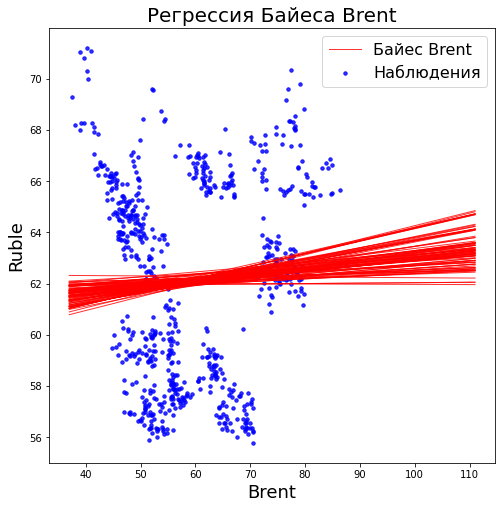

In [15]:
# OIL Байес на истории

plt.figure(figsize = (8, 8))
pm.plot_posterior_predictive_glm(linear_trace_oil, samples = 100, eval=np.linspace(37, 111, 60), linewidth = 1, 
                                 color = 'red', alpha = 0.8, label = 'Байес Brent',
                                lm = lambda x, sample: sample['Intercept'] + sample['slope'] * x)

# Пример с Brent

plt.scatter(df_train['oil'], y.values, s = 12, alpha = 0.8, c = 'blue', label = 'Наблюдения')
plt.title('Регрессия Байеса Brent', size = 20); plt.xlabel('Brent', size = 18)
plt.ylabel('Ruble', size = 18);
plt.legend(prop={'size': 16});

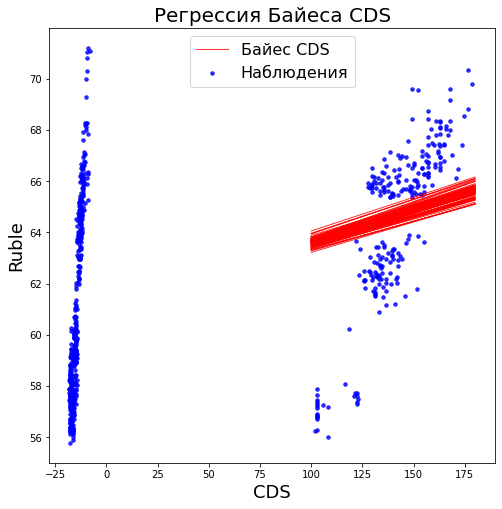

In [16]:
# cds Байес на истории

plt.figure(figsize = (8, 8))
pm.plot_posterior_predictive_glm(linear_trace_cds, samples = 100, eval=np.linspace(100, 180, 60), linewidth = 1, 
                                 color = 'red', alpha = 0.8, label = 'Байес CDS',
                                lm = lambda x, sample: sample['Intercept'] + sample['slope'] * x)

# Пример с Brent

plt.scatter(df_train['cds'], y.values, s = 12, alpha = 0.8, c = 'blue', label = 'Наблюдения')
plt.title('Регрессия Байеса CDS', size = 20); plt.xlabel('CDS', size = 18)
plt.ylabel('Ruble', size = 18);
plt.legend(prop={'size': 16});

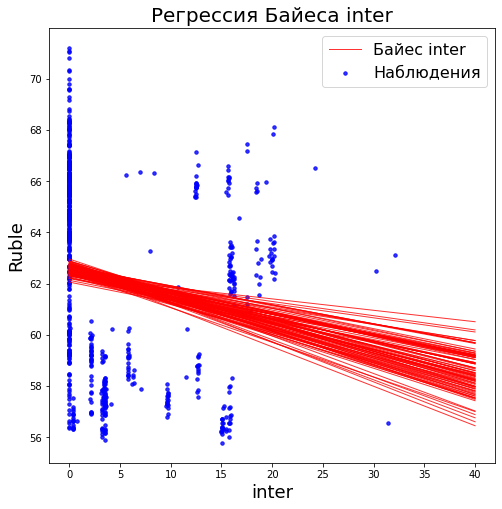

In [17]:
# inter Байес на истории

plt.figure(figsize = (8, 8))
pm.plot_posterior_predictive_glm(linear_trace_inter, samples = 100, eval=np.linspace(0, 40, 60), linewidth = 1, 
                                 color = 'red', alpha = 0.8, label = 'Байес inter',
                                lm = lambda x, sample: sample['Intercept'] + sample['slope'] * x)

# Пример с Brent

plt.scatter(df_train['inter'], y.values, s = 12, alpha = 0.8, c = 'blue', label = 'Наблюдения')
plt.title('Регрессия Байеса inter', size = 20); plt.xlabel('inter', size = 18)
plt.ylabel('Ruble', size = 18);
plt.legend(prop={'size': 16});

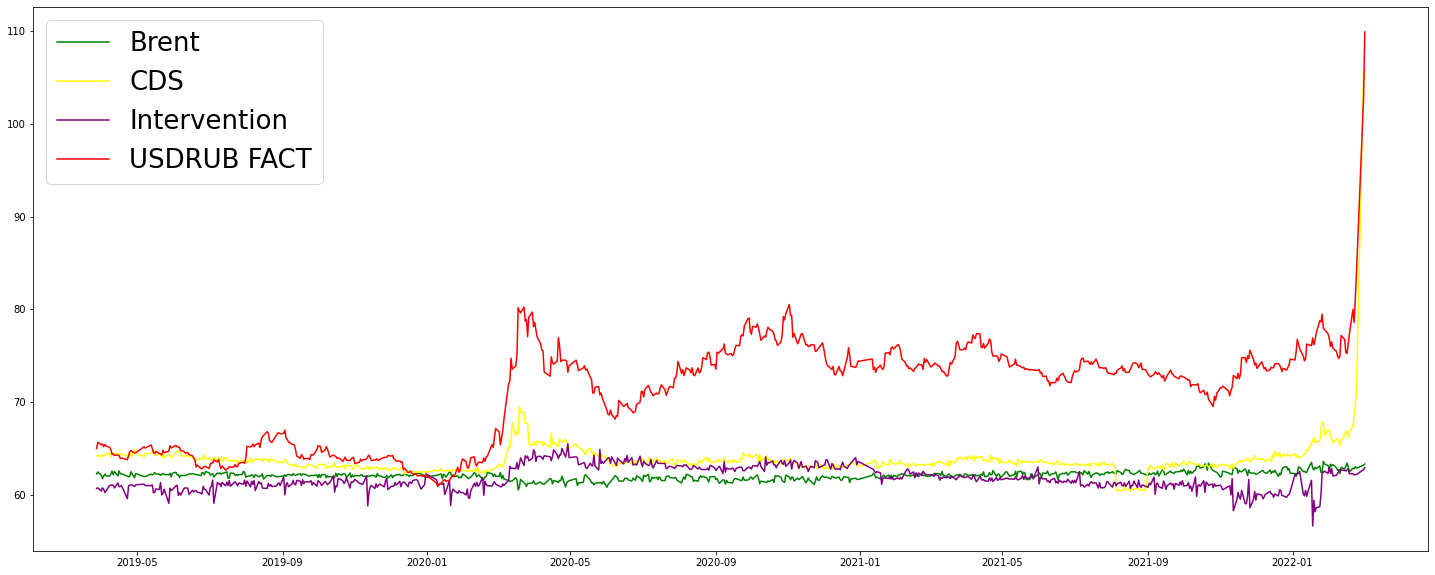

In [18]:
# Сравним между собой всех однофакторных Байесов

bayes_prediction_oil = linear_trace_oil['Intercept'] + linear_trace_oil['slope'] * df_test['oil']
bayes_prediction_cds = linear_trace_cds['Intercept'] + linear_trace_cds['slope'] * df_test['cds']
bayes_prediction_inter = linear_trace_inter['Intercept'] + linear_trace_inter['slope'] * df_test['inter'] 

rub_chart = df_test['rub']
plt.plot(bayes_prediction_oil, label='Brent',  color="green")
plt.plot(bayes_prediction_cds, label='CDS',  color="yellow") # фактор CDS волатилен и местами сильно расходится с курсом и может вывести прогноз в минус
plt.plot(bayes_prediction_inter, label='Intervention',  color="purple")
plt.plot(rub_chart,  label='USDRUB FACT', color="red")
plt.legend(prop={'size': 26});

Bayes OIL  10.554454613854139
Bayes СDS  8.772716793421441
Bayes Intervention  10.602711205996153


Text(0.5, 1.0, 'Сравнение однофакторных Байесов по ошибкам (RMSE)')

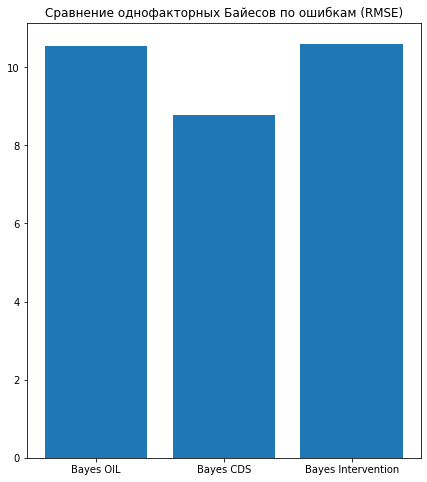

In [19]:
# Ошибки прогнозов однофакторных Байесов

from sklearn.metrics import mean_squared_error

# OIL

mse_bayes_oil = mean_squared_error(df_test['rub'], bayes_prediction_oil)
rmse_bayes_oil = math.sqrt(mse_bayes_oil)

# CDS

mse_bayes_cds = mean_squared_error(df_test['rub'], bayes_prediction_cds)
rmse_bayes_cds = math.sqrt(mse_bayes_cds)

# Intervention

mse_bayes_inter = mean_squared_error(df_test['rub'], bayes_prediction_inter)
rmse_bayes_inter = math.sqrt(mse_bayes_inter)

print('Bayes OIL ', rmse_bayes_oil)
print('Bayes СDS ', rmse_bayes_cds)
print('Bayes Intervention ', rmse_bayes_inter)

name = ['Bayes OIL', 'Bayes CDS', 'Bayes Intervention']
value = [rmse_bayes_oil, rmse_bayes_cds, rmse_bayes_inter]

plt.figure(figsize=(24, 8))
plt.subplot(131)
plt.bar(name, value)
plt.title('Сравнение однофакторных Байесов по ошибкам (RMSE)')

R^2:  0.5416257149214059


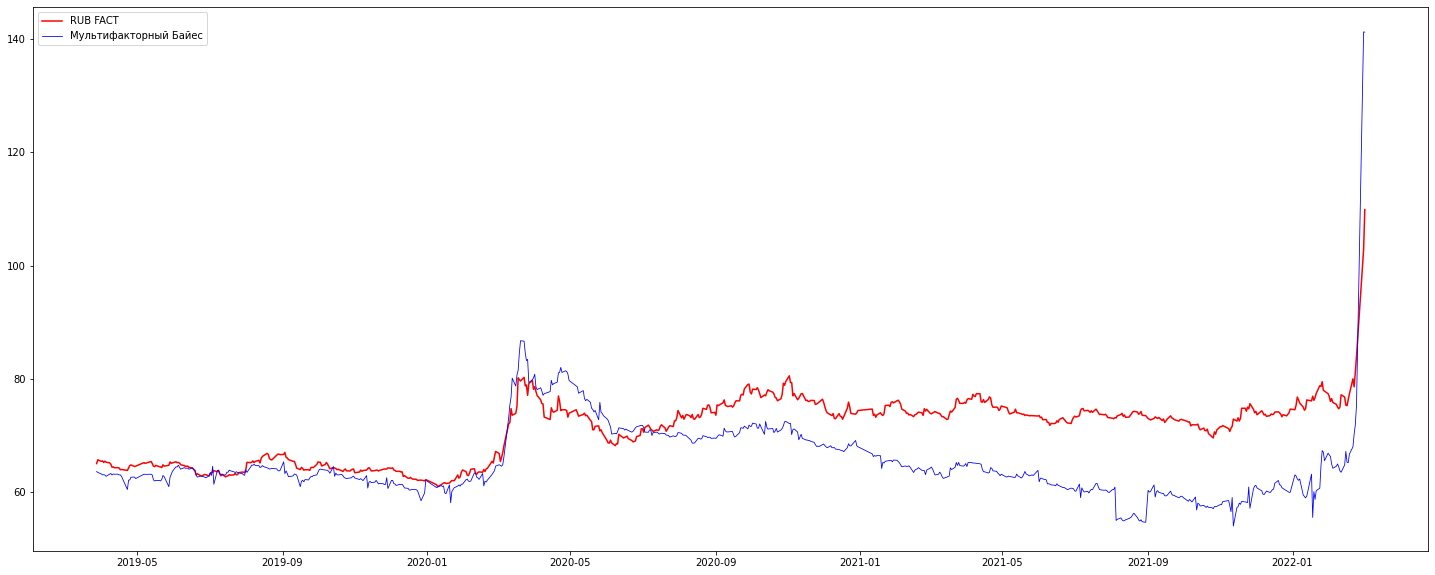

In [20]:
# Для мультифакторной модели мы используем Ridge версию регресии Байеса
# Причина в высокой корреляции используемых факторов в некоторые периоды 
# Ridge лучше справляется с этой задачей 

from sklearn.linear_model import BayesianRidge
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from numpy import sqrt

bayes = BayesianRidge(compute_score=True, n_iter=5000, alpha_1=0, alpha_2=1e-04, lambda_1=1, lambda_2=1e-03)

w = df_train[['oil','cds','inter']]
z = df_train[['rub']]
k = df_test[['oil','cds','inter']]

bayes_results = bayes.fit(w,z)

score = bayes.score(w,z)
print('R^2: ', score)

pred_bayes = bayes.predict(k)

x_ax = df_test.index
plt.plot(x_ax, df_test[['rub']],  color="red", label="RUB FACT")
plt.plot(x_ax, pred_bayes, lw=0.8, color="blue", label="Мультифакторный Байес")
plt.legend()
plt.show() 

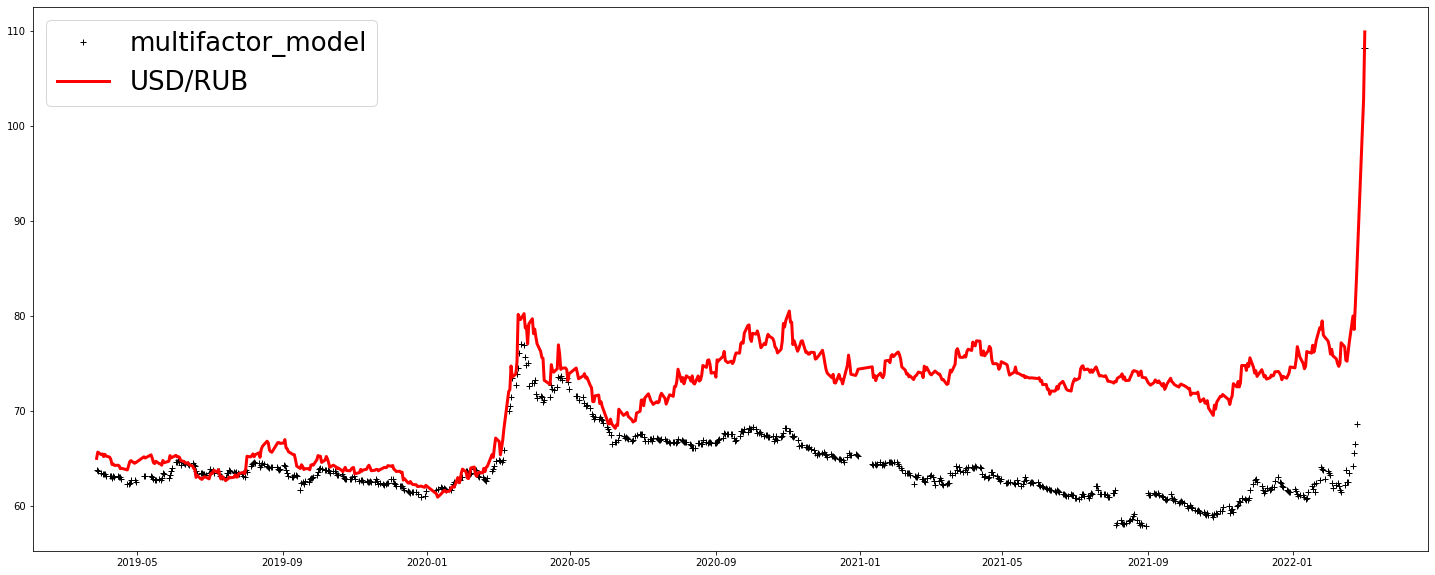

In [21]:
# Подготовка к построению графиков. Приводим к общему индексу

rub_chart = df_test['rub'] # подгружаем факт курс и отцепляем индекс
rub_chart = pd.concat([rub_chart], axis=1, keys=['rub'])
rub_chart.reset_index(inplace=True)

df_pred_gls = pd.Series(pred_gls) # преобразовываем в df наши ряды с прогнозами
df_pred_ols = pd.Series(pred_ols)

# Сшиваем ols и gls в один df и также отцепляем индекс, затем соединяем все вместе

model_charts = pd.concat([df_pred_gls, df_pred_ols], axis=1, keys=['pred_gls','pred_ols'])
model_charts.reset_index(inplace=True)
predictive_charts = pd.concat([rub_chart,model_charts['pred_gls'], model_charts['pred_ols'],],
                              axis=1, keys=['rub','pred_gls','pred_ols'])

predictive_charts.set_index(list(predictive_charts)[0], inplace=True)
predictive_charts.columns = ['rub', 'pred_gls','pred_ols']
predictive_charts.index.names = ['Date']
# Графиков прогнозов (на основе обучающей выборки) против фактического курса рубля к доллару

plt.plot(predictive_charts['pred_gls'],'k+', label = 'multifactor_model', linewidth = 0.5, color='black') # GLS прогноз
#plt.plot(predictive_charts['pred_ols'], 'k+', label = 'OLS', linewidth = 0.5, color='black') # OLS прогноз
plt.plot(predictive_charts['rub'], label = 'USD/RUB', linewidth = 3, color='r') # Фактический курс
#plt.plot(x_ax, pred_bayes, lw=3, color="green", label="Мультифакторный Байес")# Байес прогноз
plt.legend(prop={'size': 26})

In [22]:
#pred_bayes

In [23]:
predictive_charts[:792]

,rub,pred_gls,pred_ols
Date,,,
2019-03-28,65.0273,63.846136,63.620766
2019-03-29,65.6905,63.719760,63.458352
2019-04-01,65.4188,63.518522,63.175439
2019-04-02,65.4940,63.421436,63.011807
2019-04-03,65.2175,63.434727,63.054947
...,...,...,...
2022-02-22,78.5900,65.542543,70.242800
2022-02-23,81.1400,66.542002,71.899741
2022-02-24,84.0000,68.603259,75.382442


RMSE OLS  8.812148630604199
RMSE GLS  8.690989228679731
ARIMA OLS  71.35454629637015
RMSE Bayes  8.793550038236054


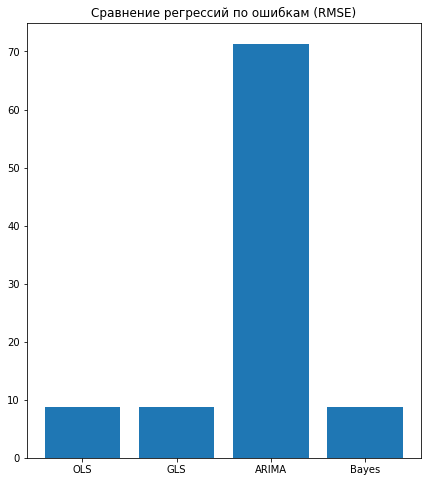

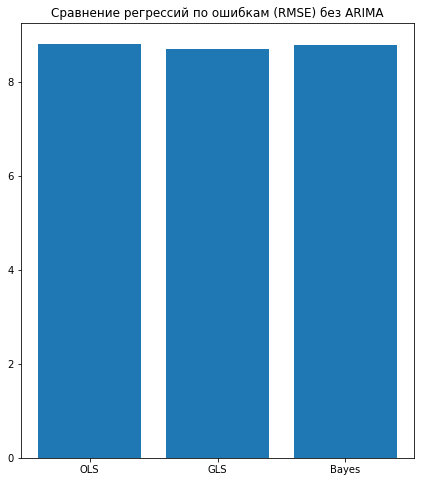

In [24]:
# Сравним наши регрессии по ошибкам. Вариант RMSE для более читаемого вида

# Расчитаем ошибку и ее квадрат исходя из прогнозных данных для каждой модели модели и факта

from sklearn.metrics import mean_squared_error

# OLS

mse_ols = mean_squared_error(df_test['rub'], pred_ols)
rmse_ols = math.sqrt(mse_ols)

# GLS

mse_gls = mean_squared_error(df_test['rub'], pred_gls)
rmse_gls = math.sqrt(mse_gls)

# ARIMA

mse_arima = mean_squared_error(df_test['rub'], pred_arima)
rmse_arima = math.sqrt(mse_arima)

# Bayes

mse_bayes = mean_squared_error(df_test['rub'], pred_bayes)
rmse_bayes = math.sqrt(mse_bayes)

# Из первого графика видно, что у всех моделей за исключением ARIMA схожий результат. Посмотрим на график без нее

names = ['OLS', 'GLS', 'ARIMA', 'Bayes']
values = [rmse_ols, rmse_gls, rmse_arima, rmse_bayes]

plt.figure(figsize=(24, 8))
plt.subplot(131)
plt.bar(names, values)
plt.title('Сравнение регрессий по ошибкам (RMSE)')

names = ['OLS', 'GLS', 'Bayes']
values = [rmse_ols, rmse_gls,  rmse_bayes]

# Результат схож с базовой статьей - результаты методов кроме ARIMA схожи, в этот раз GLS
# показал преимущество в прогнозах.

plt.figure(figsize=(24, 8))
plt.subplot(131)
plt.bar(names, values)
plt.title('Сравнение регрессий по ошибкам (RMSE) без ARIMA')


# Текстовый вариант

print('RMSE OLS ', rmse_ols)
print('RMSE GLS ', rmse_gls)
print('ARIMA OLS ', rmse_arima)
print('RMSE Bayes ', rmse_bayes)


Прогнозный курс рубля при заданных факторах  = [71.56383828]


(Text(0.5, 0, 'Курс рубля за $'), Text(0, 0.5, 'Пустая ось'))

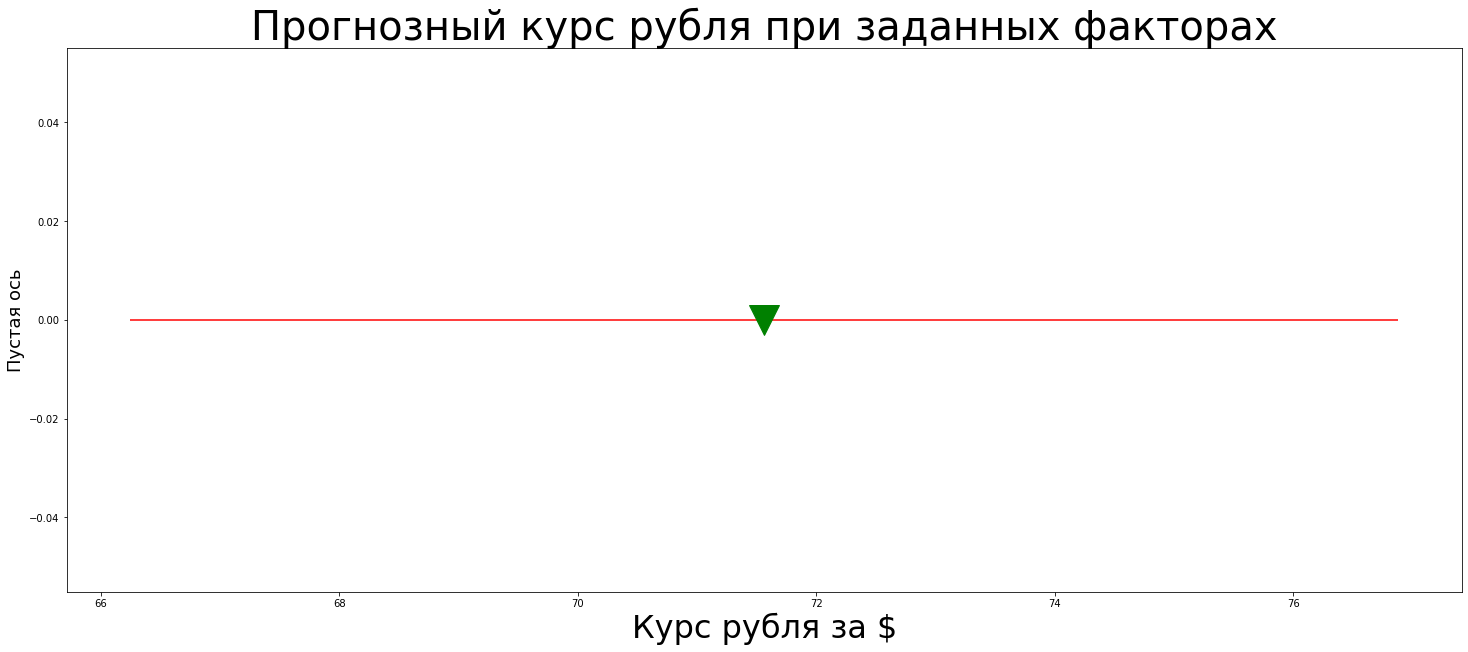

In [25]:
# Прогноз курса на основе заданного значения по Brent, CDS и Intervention. 95% доверительный интервал

# Задайте значения факторов ниже в []

factors = {'Brent': [35],
           'CDS': [90],
           'Intervention': [-6]}

forecast_factors = pd.DataFrame(factors, columns = ['Brent', 'CDS', 'Intervention'])
multi_bayes_mean, multi_bayes_std  = bayes.predict(forecast_factors, return_std=True)
#print('Прогнозный курс рубля при заданных факторах Brent, CDS и Intervention =', multi_bayes_mean)
print('Прогнозный курс рубля при заданных факторах  =', multi_bayes_mean)

plt.figure()
plt.errorbar(multi_bayes_mean, 0, xerr=2*multi_bayes_std,  fmt = 'v', ecolor = 'red', markersize='30',
            color='green')
#plt.title('Прогнозный курс рубля при заданных факторах Brent, CDS и Intervention', size = 40)
plt.title('Прогнозный курс рубля при заданных факторах', size = 40)
plt.xlabel('Курс рубля за $', size = 32), plt.ylabel('Пустая ось', size = 18)

Прогнозный курс рубля при заданных факторах  = [71.6892078]


(Text(0.5, 0, 'Курс рубля за $'), Text(0, 0.5, 'Пустая ось'))

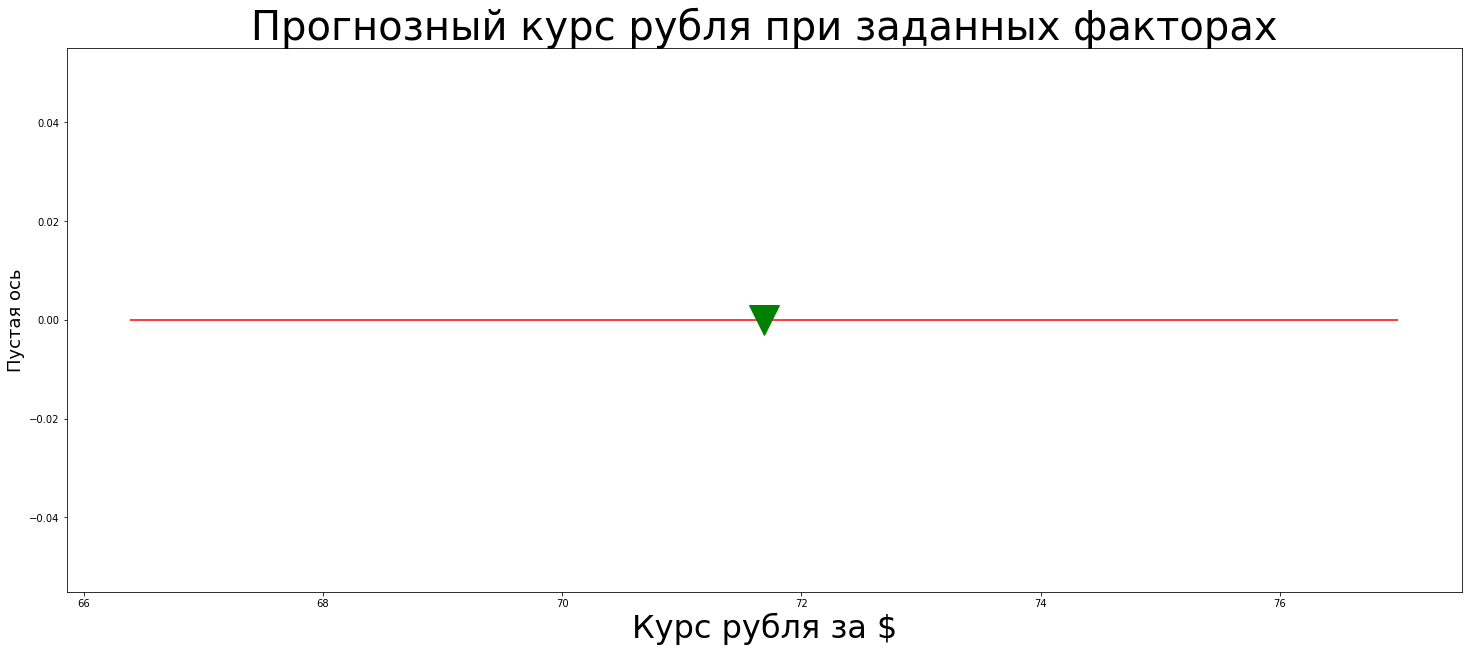

In [26]:
# Прогноз курса на основе заданного значения по Brent, CDS и Intervention. 95% доверительный интервал

# Задайте значения факторов ниже в []

factors = {'Brent': [35],
           'CDS': [100],
           'Intervention': [-3]}

forecast_factors = pd.DataFrame(factors, columns = ['Brent', 'CDS', 'Intervention'])
multi_bayes_mean, multi_bayes_std  = bayes.predict(forecast_factors, return_std=True)
#print('Прогнозный курс рубля при заданных факторах Brent, CDS и Intervention =', multi_bayes_mean)
print('Прогнозный курс рубля при заданных факторах  =', multi_bayes_mean)

plt.figure()
plt.errorbar(multi_bayes_mean, 0, xerr=2*multi_bayes_std,  fmt = 'v', ecolor = 'red', markersize='30',
            color='green')
#plt.title('Прогнозный курс рубля при заданных факторах Brent, CDS и Intervention', size = 40)
plt.title('Прогнозный курс рубля при заданных факторах', size = 40)
plt.xlabel('Курс рубля за $', size = 32), plt.ylabel('Пустая ось', size = 18)

При значении CDS в  100 прогнозный курс рубля по регрессии Байеса будет:  63.273533 RUBUSD или  0.02 USDRUB


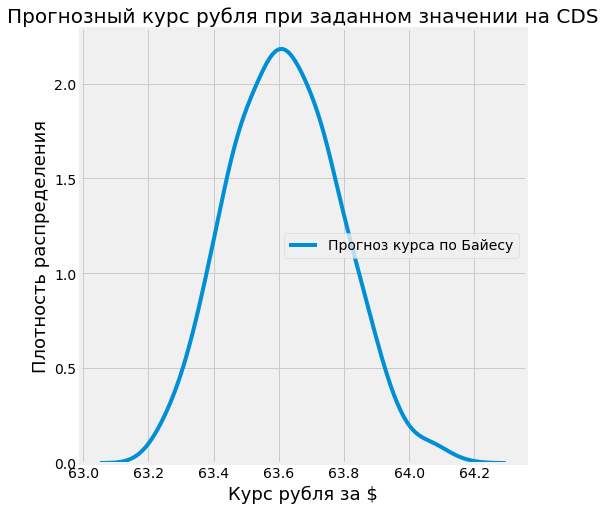

In [27]:
# Прогноз курса на основе заданного значения по CDS
# Алгоритм выдает прогнозный курс на основе 

cds_forecast = 100 # Введите сюда значение CDS по которому хотите получить прогнозный курс рубля

bayes_prediction_cds = linear_trace_cds['Intercept'] + linear_trace_cds['slope'] * cds_forecast

plt.figure(figsize = (8, 8))
plt.style.use('fivethirtyeight')
sns.kdeplot(bayes_prediction_cds, label = 'Прогноз курса по Байесу')

plt.legend();
plt.xlabel('Курс рубля за $', size = 18), plt.ylabel('Плотность распределения', size = 18);
plt.title('Прогнозный курс рубля при заданном значении на CDS', size = 20);

print('При значении CDS в ', cds_forecast, 'прогнозный курс рубля по регрессии Байеса будет: ',
      round(bayes_prediction_cds[0],6), 'RUBUSD или ', round(1/bayes_prediction_cds[0],2), 'USDRUB')

# Вероятность прогноза по Байесу по данному интервалу и кол-ву итераций = 91.4%, но показатель будет менятся при
# других параметрах. Посмотреть новое значение можно в розовом боксе после запуска Байеса with pm.Model() as linear_model:

При значении inter в  10 прогнозный курс рубля по регрессии Байеса будет:  61.578907 RUBUSD или  0.02 USDRUB


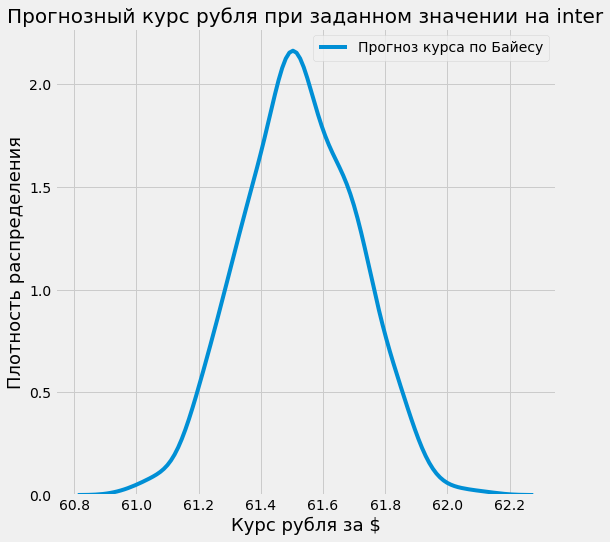

In [28]:

# Прогноз курса на основе заданного значения по Резервам
# Алгоритм выдает прогнозный курс на основе 

inter_forecast = 10 # Введите сюда значение inter по которому хотите получить прогнозный курс рубля

bayes_prediction_inter = linear_trace_inter['Intercept'] + linear_trace_inter['slope'] * inter_forecast

plt.figure(figsize = (8, 8))
plt.style.use('fivethirtyeight')
sns.kdeplot(bayes_prediction_inter, label = 'Прогноз курса по Байесу')

plt.legend();
plt.xlabel('Курс рубля за $', size = 18), plt.ylabel('Плотность распределения', size = 18);
plt.title('Прогнозный курс рубля при заданном значении на inter', size = 20);

print('При значении inter в ', inter_forecast, 'прогнозный курс рубля по регрессии Байеса будет: ',
      round(bayes_prediction_inter[0],6), 'RUBUSD или ', round(1/bayes_prediction_inter[0],2), 'USDRUB')


# Вероятность прогноза по Байесу по данному интервалу и кол-ву итераций = 97.72%, но показатель будет менятся при
# других параметрах. Посмотреть новое значение можно в розовом боксе после запуска Байеса with pm.Model() as linear_model: